## 导入包

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
import sys
import pandas as pd
import datetime

## 超参数设定

In [48]:
k = 40
sticks = ['start_x', 'start_y', 'end_x', 'end_y']
src_path = sys.path[0]
relative_path = "../Data"
csv_file = "shanghaidataset.csv"
# csv_file = "train.csv"
savefigpath = src_path + "/../Pic/"
# savefigpath = None
showfig = True
# showfig = False

## 函数定义

In [49]:
def KMeansDisplay(data: np.ndarray[float, float], n_clusters: int, title: str=None, normalize: bool=True, savefigpath:str=None, showfig: bool=True) -> list[np.ndarray]:
    # 使用 K-Means 进行聚类
    kmeans = KMeans(n_clusters)
    if normalize:
        normalized_data = (data - np.mean(data))/ np.std(data)
        kmeans.fit(normalized_data)
    else:
        kmeans.fit(data)

    # 获取聚类的中心点
    centroids = kmeans.cluster_centers_ * np.std(data) + np.mean(data) if normalize else kmeans.cluster_centers_

    # 获取每个数据点所属的簇标签
    labels = kmeans.labels_

    # 展示聚类结果
    plt.cla()
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap="rainbow")
    plt.scatter(
        centroids[:, 0], centroids[:, 1], marker="X", s=20, c="black", label="Centroids"
    )
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")
    if title:
        plt.title(title)
    else:
        plt.title("K-Means Clustering")
    plt.legend()
    if savefigpath:
        plt.savefig(savefigpath + title)
    if showfig:
        plt.show()
    return centroids, labels


def CalTime(data: str):
    time = datetime.datetime.strptime(data, "%Y/%m/%d %H:%M")
    return time.hour * 60 + time.minute


def ElbowMethod(data, max_k):
    # data: 输入的数据集，格式为 N * D，N 表示样本数，D 表示特征数
    # max_k: 最大的簇数量 K 的上限

    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)  # inertia_ 表示损失函数值（平方和误差）

    # 绘制 K 值和损失函数值曲线
    plt.plot(range(1, max_k + 1), distortions, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Distortion (Loss Function Value)')
    plt.title('Elbow Method for Optimal K')
    plt.show()


def HaversineDistance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on the Earth's surface using the Haversine formula.

    Parameters:
        lat1 (numpy.ndarray): Array of latitudes of points from set 1 in degrees.
        lon1 (numpy.ndarray): Array of longitudes of points from set 1 in degrees.
        lat2 (numpy.ndarray): Array of latitudes of points from set 2 in degrees.
        lon2 (numpy.ndarray): Array of longitudes of points from set 2 in degrees.

    Returns:
        distances (numpy.ndarray): 2D array containing distances between all pairs of points in kilometers.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = np.radians(lat1), np.radians(lon1), np.radians(lat2), np.radians(lon2)

    # Haversine formula
    dlat = lat2[:, np.newaxis] - lat1
    dlon = lon2[:, np.newaxis] - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2[:, np.newaxis]) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    earth_radius = 6371  # Earth's radius in kilometers
    distances = earth_radius * c
    return distances


def MinWeightPerfectMatching(matrix):
    row_idx, col_idx = linear_sum_assignment(matrix)
    matching_cost = matrix[row_idx, col_idx].sum()
    return matching_cost, list(zip(row_idx, col_idx))


def ClustersPairs(start_centroids: np.ndarray, end_centroids: np.ndarray, title: str=None, savefigpath:str=None, showfig: bool=True):
    clusters = np.hstack((start_centroids, end_centroids))

    Tclusters = clusters.T
    distances = HaversineDistance(Tclusters[0], Tclusters[1], Tclusters[2], Tclusters[3])

    matching_cost, matching_pairs = MinWeightPerfectMatching(distances)
    matching_pairs = np.array(matching_pairs)
    tmp_x = np.stack((start_centroids[matching_pairs[:, 1], 0], end_centroids[:, 0])).T
    tmp_y = np.stack((start_centroids[matching_pairs[:, 1], 1], end_centroids[:, 1])).T

    # 展示聚类结果
    plt.cla()
    plt.scatter(
        start_centroids[:, 0],
        start_centroids[:, 1],
        marker="X",
        s=20,
        c="red",
        label="Start Centroids",
        alpha=0.8,
    )
    plt.scatter(
        end_centroids[:, 0],
        end_centroids[:, 1],
        marker="o",
        s=20,
        c="blue",
        label="End Centroids",
        alpha=0.8,
    )
    for i in range(len(matching_pairs)):
        plt.plot(tmp_x[i], tmp_y[i])

    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")
    plt.legend()
    if title:
        plt.title(title)
    else:
        plt.title("K-Means Clustering")
    if savefigpath:
        plt.savefig(savefigpath + title)
    if showfig:
        plt.show()
    return matching_cost, matching_pairs

## 读取文件

In [50]:
data_ndarray = pd.read_csv("/".join([src_path, relative_path, csv_file]))

data_ndarray = data_ndarray.loc[
    :,
    [
        "start_time",
        "end_time",
        "start_location_y",
        "start_location_x",
        "end_location_y",
        "end_location_x",
    ],
].to_numpy()
data_ndarray[:, 0:2] = np.vectorize(CalTime)(data_ndarray[:, 0:2])
start_loc = data_ndarray[:, [2, 3]]
end_loc = data_ndarray[:, [4, 5]]

## 检查异常值

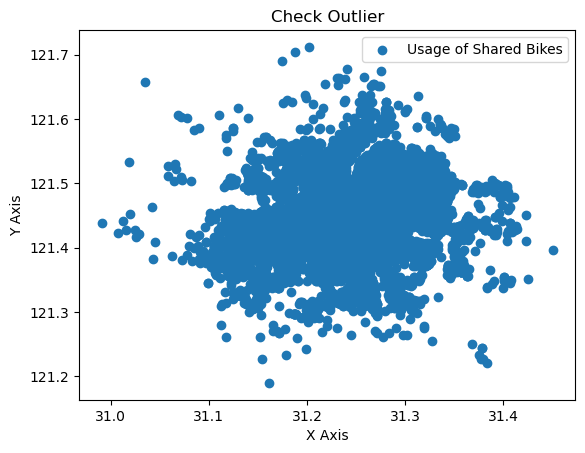

In [51]:
# 展示聚类结果
title = "Check Outlier"
plt.cla()
plt.scatter(start_loc[:, 0], start_loc[:, 1], label="Usage of Shared Bikes")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.title(title)
plt.legend()
if savefigpath:
    plt.savefig(savefigpath + title)
if showfig:
    plt.show()

## 肘形图判断最佳簇数量

[[31.103 121.387]
 [31.321 121.534]
 [31.328 121.539]
 ...
 [31.29 121.538]
 [31.218 121.43]
 [31.237 121.484]]


/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/lin/opt/a

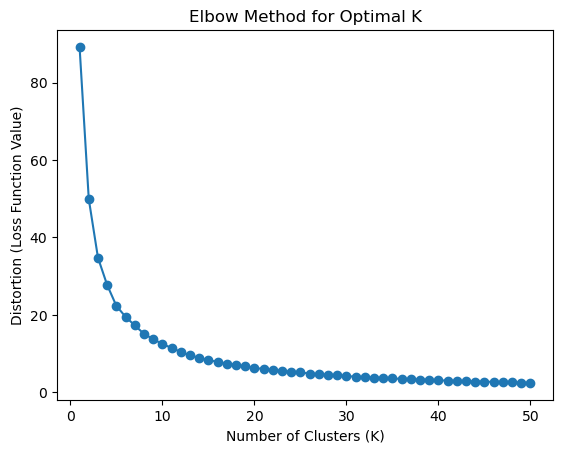

In [52]:
data = data_ndarray[:, 2:4]
print(data)
# 设置最大的簇数量 K 的上限
max_k = 50

# 使用肘方法判断最佳的簇数量 K
ElbowMethod(data, max_k)


## 绘制分时聚类图

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


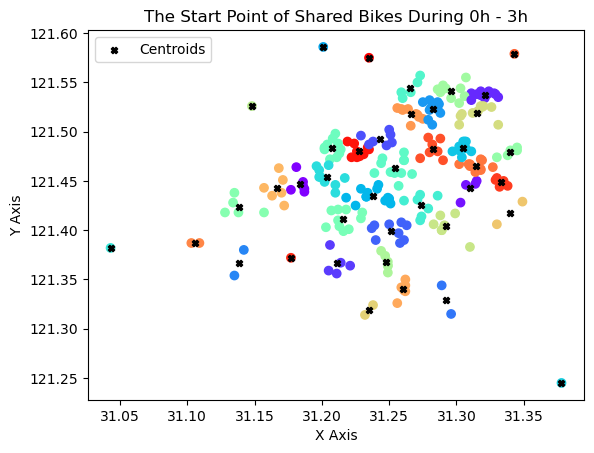

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


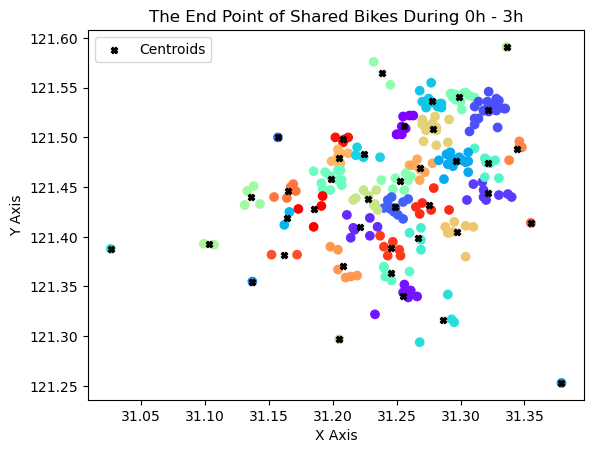

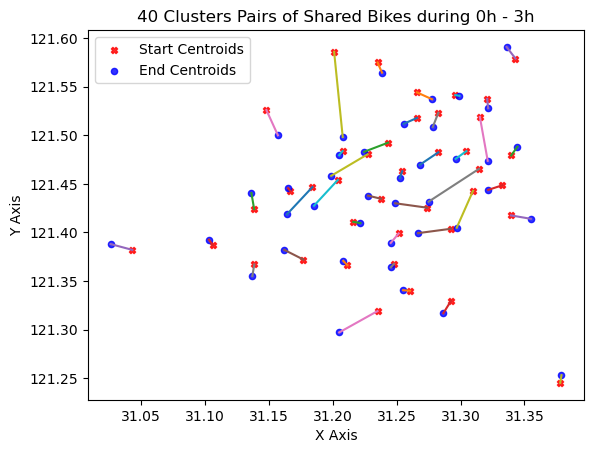

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


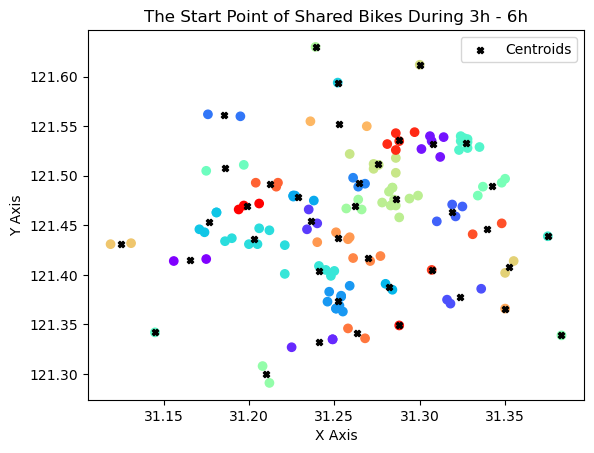

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


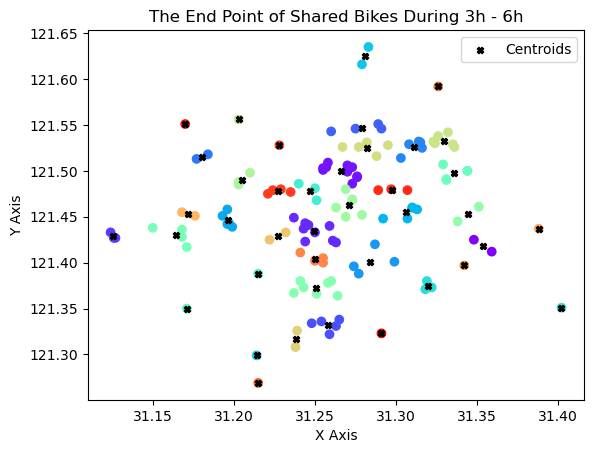

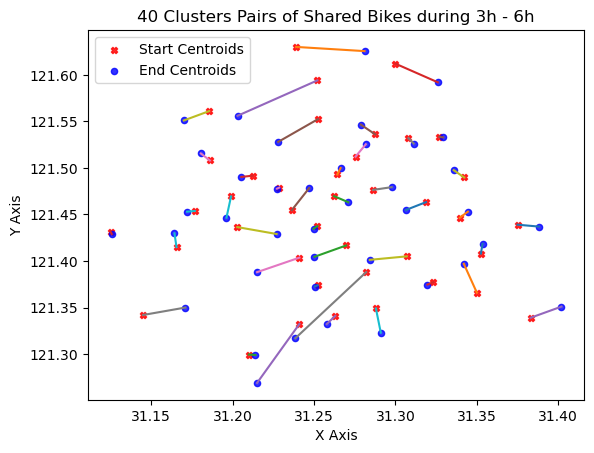

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


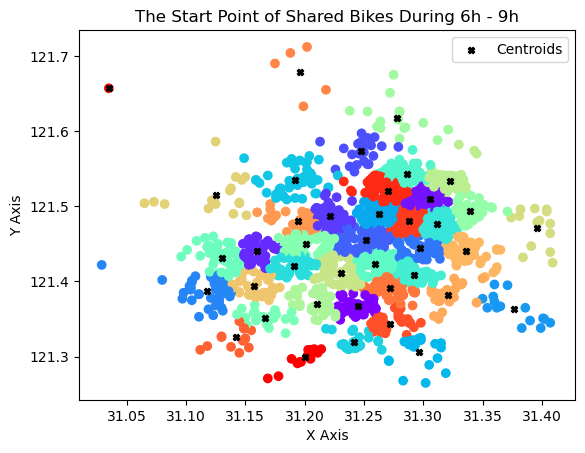

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


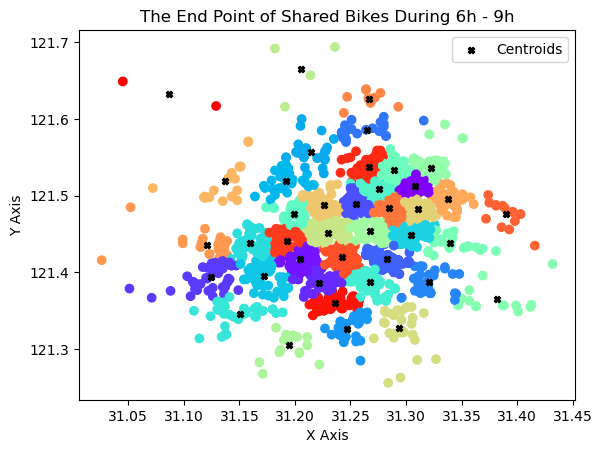

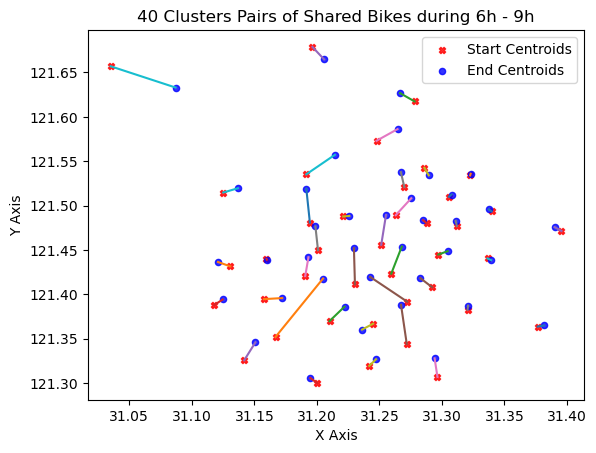

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


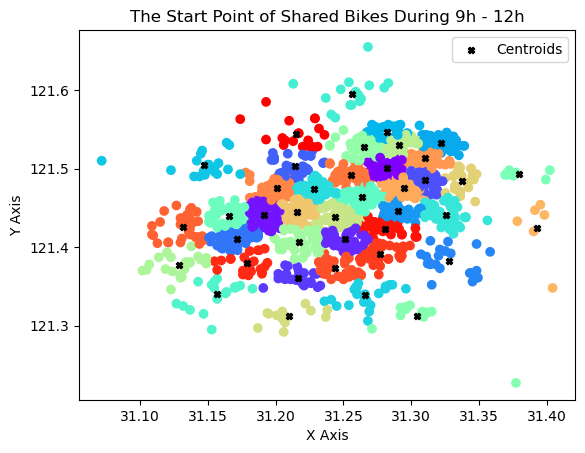

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


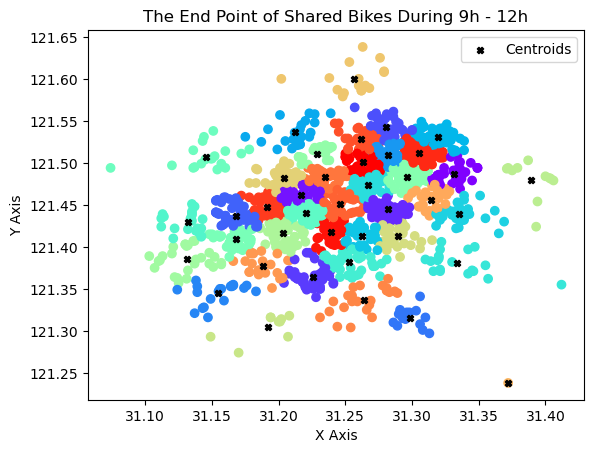

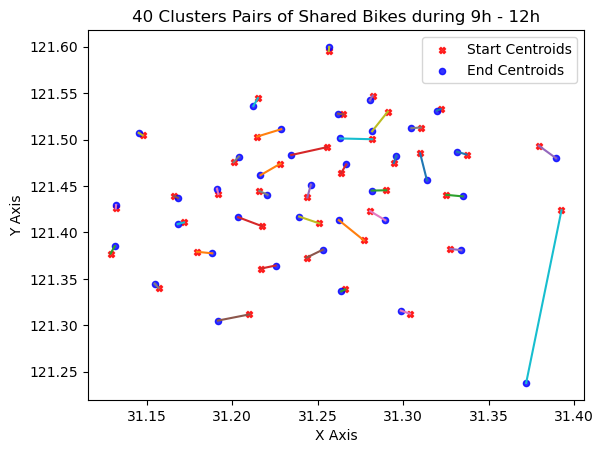

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


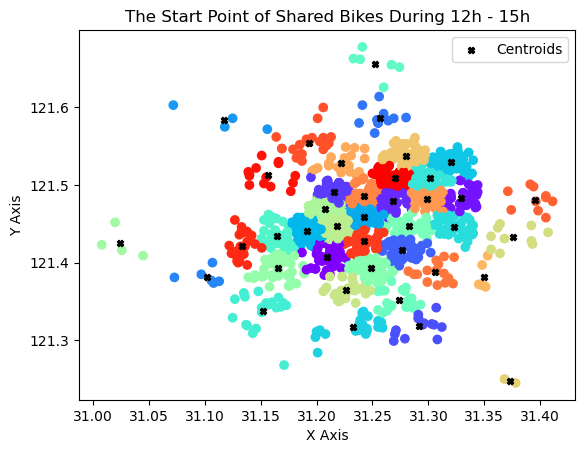

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


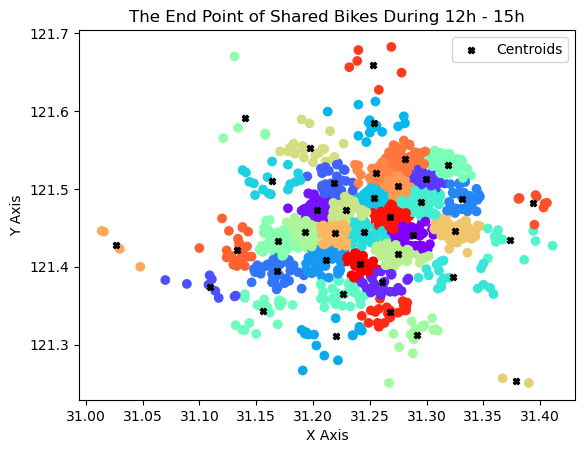

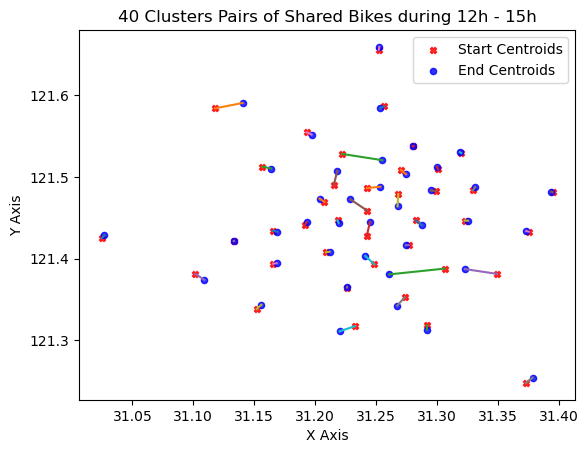

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


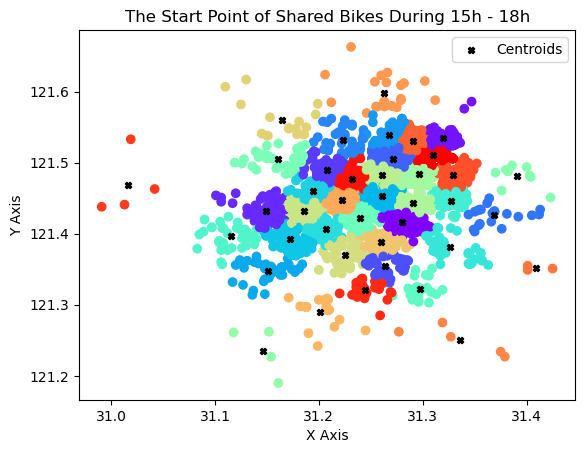

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


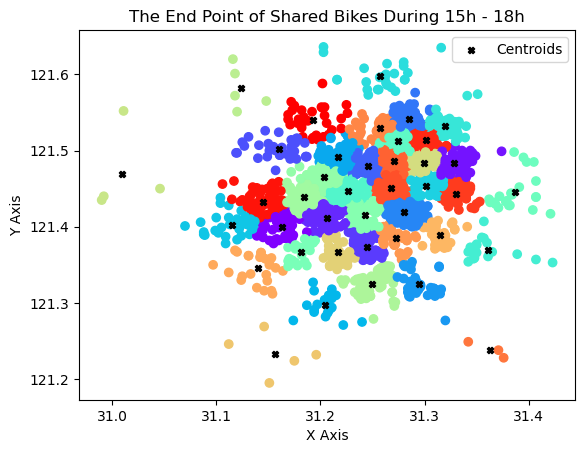

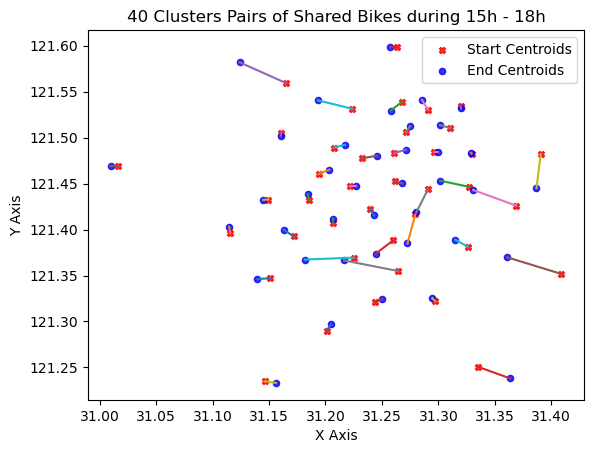

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


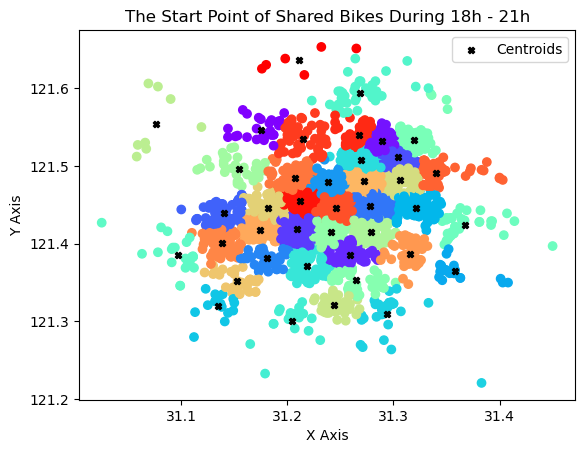

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


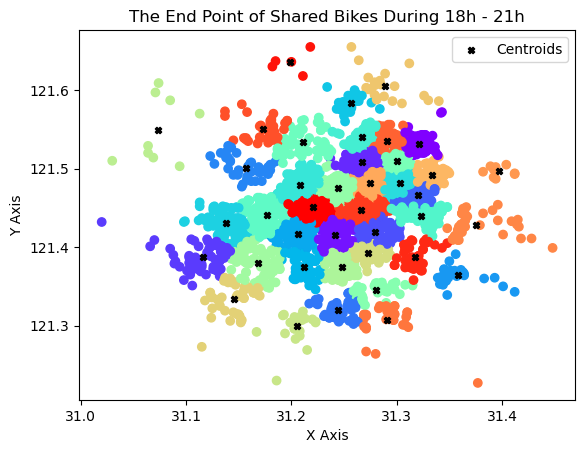

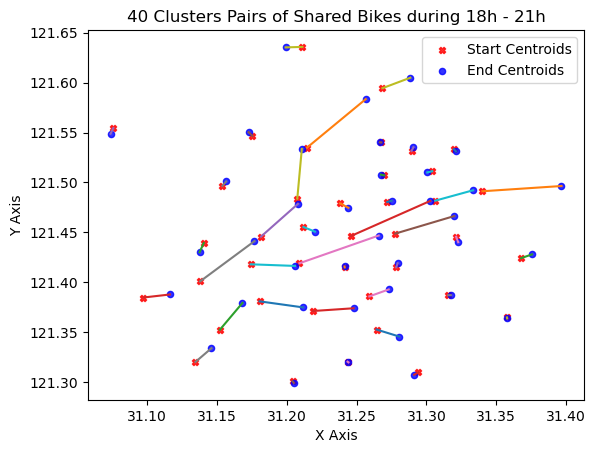

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


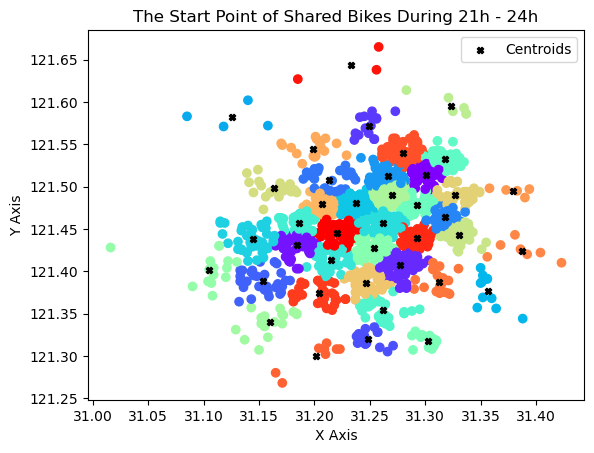

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


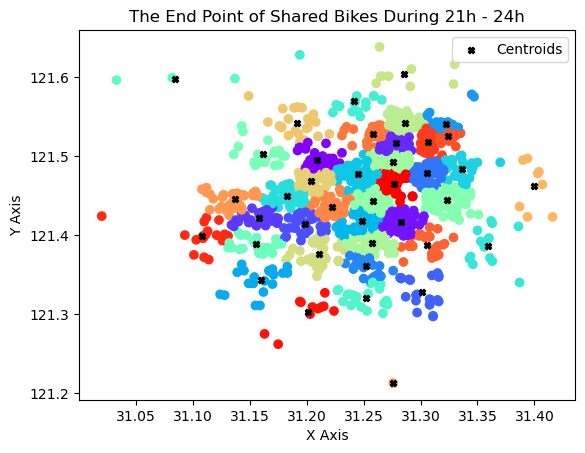

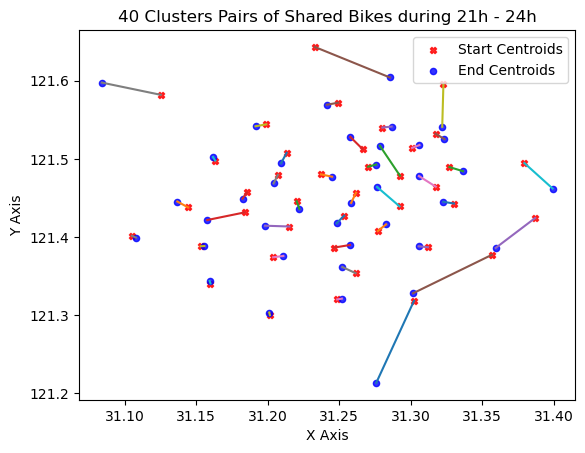

In [53]:
for hour in range(0, 24, 3):
    tmp_start_loc = start_loc[(data_ndarray[:, 0] > hour * 60) & (data_ndarray[:, 0] <= (hour + 3) * 60), :]
    tmp_end_loc = end_loc[(data_ndarray[:, 0] > hour * 60) & (data_ndarray[:, 0] <= (hour + 3) * 60), :]
    start_centroids, _ = KMeansDisplay(tmp_start_loc, 40, title = f"The Start Point of Shared Bikes During {hour}h - {hour + 3}h", showfig=showfig, savefigpath=savefigpath)
    end_centroids, _ = KMeansDisplay(tmp_end_loc, 40, title = f"The End Point of Shared Bikes During {hour}h - {hour + 3}h", showfig=showfig, savefigpath=savefigpath)
    ClustersPairs(start_centroids, end_centroids, title = f"40 Clusters Pairs of Shared Bikes during {hour}h - {hour + 3}h", showfig=showfig, savefigpath=savefigpath)

## 绘制全日出发/终点聚类图

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


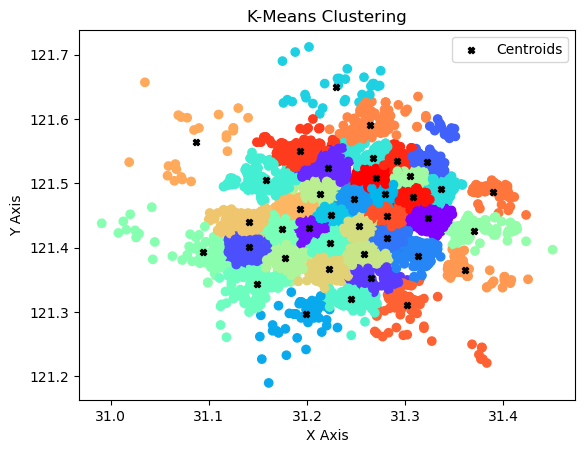

/Users/lin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


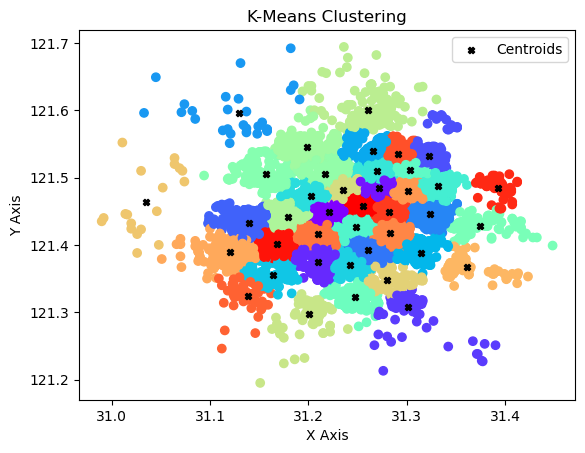

In [54]:
start_centroids, _ = KMeansDisplay(start_loc, k)
end_centroids, _ = KMeansDisplay(end_loc, k)

## 绘制全日出发/终点聚类簇中心

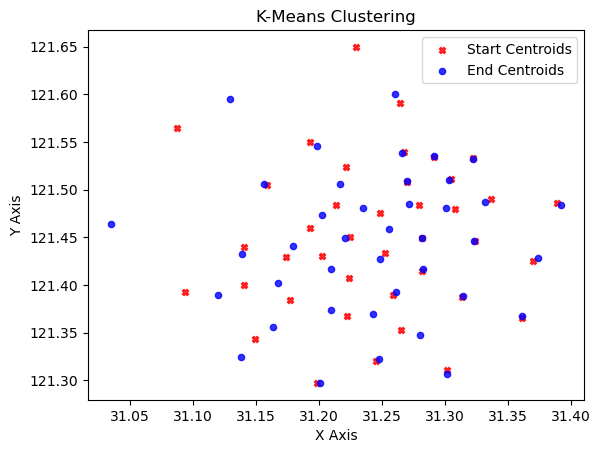

In [55]:
# 展示聚类簇结果
plt.cla()
plt.scatter(
    start_centroids[:, 0], start_centroids[:, 1], marker="X", s=20, c="red", label="Start Centroids", alpha=0.8
)
plt.scatter(
    end_centroids[:, 0], end_centroids[:, 1], marker="o", s=20, c="blue", label="End Centroids", alpha=0.8
)
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.title("K-Means Clustering")
plt.legend()
plt.show()

## 保存全日出发/终点聚类簇中心坐标

In [56]:
clusters = np.hstack((start_centroids, end_centroids))

df = pd.DataFrame(clusters, columns=sticks)
df.to_csv(src_path + f"/../Data/ClustersPoints{k}.csv")

## 计算出发点集与终点点集中元素两两之间的距离

In [57]:
Tclusters = clusters.T
distances = HaversineDistance(Tclusters[0], Tclusters[1], Tclusters[2], Tclusters[3])
print(distances)

[[11.4034998   2.70587019  7.0702502  ... 11.25841145 10.13401049
   7.80895225]
 [ 6.85123151  9.24475237  6.68965855 ...  5.20304476  4.11712712
   2.22350992]
 [14.34988267  5.45895557 14.28083202 ... 17.72898168 14.83932282
  14.38602991]
 ...
 [ 8.48161776 21.7150504  19.36514381 ... 12.19753353  9.34776205
  13.79098598]
 [17.78866062  4.73210862 13.04366761 ... 18.64454661 17.27353549
  15.20419645]
 [ 7.58865011  6.51079086  7.3036127  ...  8.22594158  6.15245535
   4.97565613]]


## 最小权重完备匹配

In [58]:
matching_cost, matching_pairs = MinWeightPerfectMatching(distances)
matching_pairs = np.array(matching_pairs)
print("最小权重完备匹配的距离之和:", matching_cost)
print("匹配对:", matching_pairs)

最小权重完备匹配的距离之和: 62.46945199126301
匹配对: [[ 0 11]
 [ 1 10]
 [ 2 27]
 [ 3 34]
 [ 4  5]
 [ 5 28]
 [ 6 25]
 [ 7  0]
 [ 8 12]
 [ 9 14]
 [10  7]
 [11 23]
 [12 17]
 [13 29]
 [14 39]
 [15 13]
 [16 26]
 [17 22]
 [18 16]
 [19 21]
 [20 15]
 [21  2]
 [22 36]
 [23 19]
 [24 32]
 [25  9]
 [26 24]
 [27  3]
 [28 30]
 [29 31]
 [30 20]
 [31 38]
 [32  6]
 [33  1]
 [34 18]
 [35 37]
 [36 35]
 [37 33]
 [38  4]
 [39  8]]


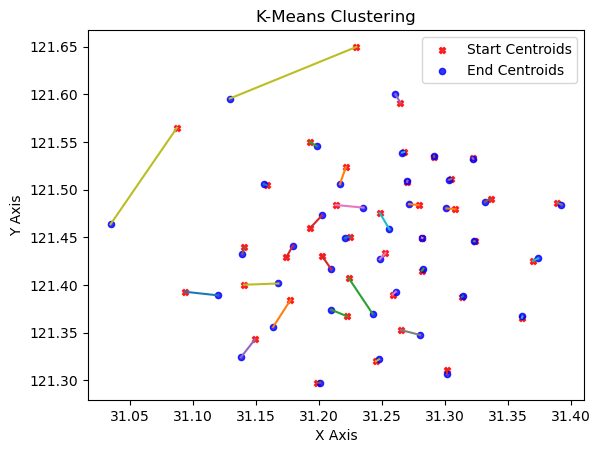

In [62]:
# 展示聚类结果
plt.cla()
plt.scatter(
    start_centroids[:, 0],
    start_centroids[:, 1],
    marker="X",
    s=20,
    c="red",
    label="Start Centroids",
    alpha=0.8,
)
plt.scatter(
    end_centroids[:, 0],
    end_centroids[:, 1],
    marker="o",
    s=20,
    c="blue",
    label="End Centroids",
    alpha=0.8,
)

tmp_x = np.stack((start_centroids[matching_pairs[:, 1], 0], end_centroids[:, 0])).T
tmp_y = np.stack((start_centroids[matching_pairs[:, 1], 1], end_centroids[:, 1])).T


df = pd.DataFrame(np.stack((tmp_x[:, 0], tmp_y[:, 0], tmp_x[:, 1], tmp_y[:, 1])).T, columns=sticks)
df.to_csv(src_path + f"/../Data/ClustersPoints{k}WithPairs.csv")


for i in range(len(matching_pairs)):
    plt.plot(tmp_x[i], tmp_y[i])


plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.title("K-Means Clustering")
plt.legend()
plt.show()

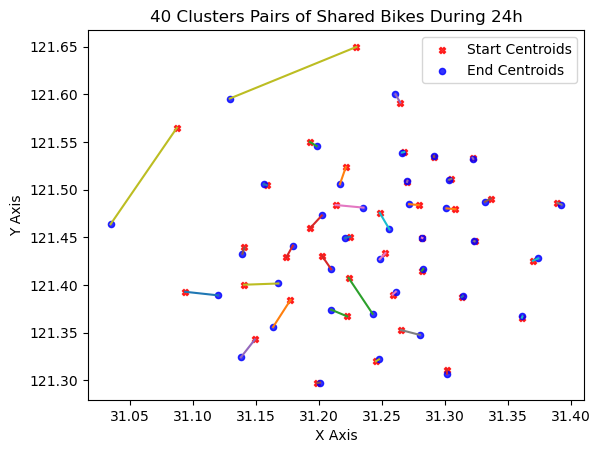

(62.46945199126301,
 array([[ 0, 11],
        [ 1, 10],
        [ 2, 27],
        [ 3, 34],
        [ 4,  5],
        [ 5, 28],
        [ 6, 25],
        [ 7,  0],
        [ 8, 12],
        [ 9, 14],
        [10,  7],
        [11, 23],
        [12, 17],
        [13, 29],
        [14, 39],
        [15, 13],
        [16, 26],
        [17, 22],
        [18, 16],
        [19, 21],
        [20, 15],
        [21,  2],
        [22, 36],
        [23, 19],
        [24, 32],
        [25,  9],
        [26, 24],
        [27,  3],
        [28, 30],
        [29, 31],
        [30, 20],
        [31, 38],
        [32,  6],
        [33,  1],
        [34, 18],
        [35, 37],
        [36, 35],
        [37, 33],
        [38,  4],
        [39,  8]]))

In [60]:
ClustersPairs(start_centroids, end_centroids, title="40 Clusters Pairs of Shared Bikes During 24h", savefigpath=savefigpath, showfig=showfig)